In [1]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

self_tuning = 1
Uncertainty = 0
switching = 0
dist = 0

import sys
from math import isnan, pi
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

plt.close('all')

import torch
import torch.nn as nn
import torch.optim as optim

from utils.Quadcopter_Dynamics import Quadcopter_Dynamics_with_Disturbance, Add_Noise
from utils.A2C_models.A2C_model import NewAgent
from utils import QuadParams
from utils.util_functions import Saturation, Reward, reset_parameters, reset_params
from utils.SMC_Controller import SMC

In [2]:
Parameters = QuadParams

In [3]:
class my_struct:
    min = 0
    max = 0


def GainBound(static_gain, coef1=0.3, coef2=2):
    out = my_struct()
    out.min, out.max = static_gain * coef1, static_gain * coef2
    return out

In [4]:
global dt, T, Tf

# Model Dynamics Parameters 

In [5]:
print("Model Parameters ...")
global m, g
global l, b, d
global Jx, Jy, Jz
global a1, a2, a3
global b1, b2, b3

m, g, l = Parameters.m, Parameters.g, Parameters.l
Jx, Jy, Jz = Parameters.Jx, Parameters.Jy, Parameters.Jz
b, d = Parameters.b, Parameters.d
a1, a2, a3 = Parameters.a1, Parameters.a2, Parameters.a3
b1, b2, b3 = Parameters.b1, Parameters.b2, Parameters.b3

print("Initialize Requirements ...")
dt = 0.01
T = dt
Tf = 10
t = np.arange(0, Tf + dt, dt)
N = int(Tf / dt) + 1
n = 12 + 3
x0 = np.zeros((n, 1))
x = x0
Xs = np.zeros((N + 1, n))
y = np.zeros((6, 1))
Uxy = np.array([0, 0])


# dt: Time step size (0.01 seconds).
# T: Current time step (starts at dt).
# Tf: Final time for the simulation (100 seconds).
# t: Array of time steps from 0 to Tf with step size dt.
# N: Total number of time steps in the simulation.
# x0: Initial state vector (all zeros).
# x: Current state, initialized to x0.
# Xs: Array to store states at each time step for analysis or visualization.
# y: Measurement vector (e.g., position, velocity, or other observed variables).
# Uxy: Placeholder for lateral control inputs (e.g., roll and pitch).
# U: A 1x4 array for storing motor commands or control inputs (e.g., thrust for four rotors).
# u: A 4x1 column vector for current control inputs, matching U.

U = np.zeros((1, 4))
u = np.zeros((4, 1))

Xd = np.zeros((N + 1, n))  #desired state at each time-step
Xm = np.zeros((N + 1, n))  #measured state at each time-step
m0 = m
M = m0 * np.ones((N + 1, 1))

Model Parameters ...
Initialize Requirements ...


# Reinforcement Learning Parameters 
# Value functions--- Rewards------Temporal difference Error

In [6]:
# V_z, V_phi, V_tta, V_psi  -->	Store the value function estimates for altitude, roll, pitch, and yaw.
# R_z, R_phi, R_tta, R_psi   -->	Store rewards for altitude, roll, pitch, and yaw at each time step.
# delta_z, delta_phi, delta_tta, delta_psi  -->	Store the TD errors for altitude, roll, pitch, and yaw.

V_z = np.zeros((N + 1, 1))          
R_z = np.zeros((N + 1, 1))
delta_z = np.zeros((N + 1, 1))
V_phi = np.zeros((N + 1, 1))
R_phi = np.zeros((N + 1, 1))
delta_phi = np.zeros((N + 1, 1))
V_tta = np.zeros((N + 1, 1))
R_tta = np.zeros((N + 1, 1))
delta_tta = np.zeros((N + 1, 1))
V_psi = np.zeros((N + 1, 1))
R_psi = np.zeros((N + 1, 1))
delta_psi = np.zeros((N + 1, 1))

# Create Desired Signal for tracking

In [ ]:
# ------Track a Constant point in 3D world
# Xd[:-1, 6] = 1
# Xd[:-1, 8] = 1
# Xd[:-1,10] = 3

# ------- Track a Square path in a constant altitude in 3D world
Xd[:-1, 4] = np.deg2rad(10 * signal.square(5 * np.pi / Tf * t))
Xd[:, 6] = 1
Xd[:-1, 8] = 1 + signal.square(4 * np.pi / Tf * t)
Xd[:-1, 10] = 1 + signal.square(4 * np.pi / Tf * (t - Tf / 8))

# ----Track a Helical path in 3D world
# Xd[:-1,  4] = np.deg2rad(np.sin(5*np.pi/Tf*t))
# Xd[:-1,  6] = 0.05*t
# Xd[:-1,  8] = np.cos(4*np.pi/Tf*t)  
# Xd[:-1, 10] = np.sin(4*np.pi/Tf*t)


# ----Track a Circular path in 3D world
# radius = 2  # Radius of the circle
# center_x = 1  # Center of the circle in X
# center_y = 1  # Center of the circle in Y
# Xd[:-1, 8] = center_x + radius * np.cos(2 * np.pi / Tf * t)  # X position
# Xd[:-1, 10] = center_y + radius * np.sin(2 * np.pi / Tf * t)  # Y position
# Xd[:-1, 6] = 1  # Z position (altitude remains constant at 1)


# ----Track a Parabolic path in 3D world
# a = 0.05  # Coefficient for the parabolic curve
# Xd[:-1, 8] = 1  # X position (constant)
# Xd[:-1, 10] = 1  # Y position (constant)
# Xd[:-1, 6] = a * (t - Tf/2)**2  # Parabolic trajectory in Z


# Track a Sinusoidal Path in 3D world
# amplitude = 1
# frequency = 0.5
# Xd[:-1, 8] = amplitude * np.sin(2 * np.pi * frequency * t)  # X position
# Xd[:-1, 10] = amplitude * np.sin(2 * np.pi * frequency * t)  # Y position
# Xd[:-1, 6] = amplitude * np.sin(2 * np.pi * frequency * t)  # Z position


# Subsystems bounds for z
Sigma_domain_z = 0.5
Sigma_domain_phi, Sigma_domain_tta, Sigma_domain_psi = pi / 36.0, pi / 36.0, pi / 36.0


# PID Control Initialization 

In [8]:
# -----------------  Static Gains   -----------------------------------#

print("Initialize PID Params ...")
Kp_x_static = 7 * 3.1415 / 180
Ki_x_static = 0
Kd_x_static = 7 * 3.1415 / 180

Kp_y_static = 7 * 3.1415 / 180
Ki_y_static = 0
Kd_y_static = 7 * 3.1415 / 180

Kp_z_static = 15
Ki_z_static = 2
Kd_z_static = 15

Kp_psi_static = 3.0
Ki_psi_static = 0.0
Kd_psi_static = 0.3

Kp_phi_static = 0.5
Ki_phi_static = 0.0
Kd_phi_static = 0.2

Kp_tta_static = 0.5
Ki_tta_static = 0.0
Kd_tta_static = 0.2

Initialize PID Params ...


In [9]:
# -------------------    Dynamic Gains  ------------------------------------#

Kp_x_dynamic = np.zeros((N + 1, 1))
Ki_x_dynamic = np.zeros((N + 1, 1))
Kd_x_dynamic = np.zeros((N + 1, 1))

Kp_y_dynamic = np.zeros((N + 1, 1))
Ki_y_dynamic = np.zeros((N + 1, 1))
Kd_y_dynamic = np.zeros((N + 1, 1))

Kp_z_dynamic = np.zeros((N + 1, 1))
Ki_z_dynamic = np.zeros((N + 1, 1))
Kd_z_dynamic = np.zeros((N + 1, 1))

Kp_psi_dynamic = np.zeros((N + 1, 1))
Ki_psi_dynamic = np.zeros((N + 1, 1))
Kd_psi_dynamic = np.zeros((N + 1, 1))

Kp_phi_dynamic = np.zeros((N + 1, 1))
Ki_phi_dynamic = np.zeros((N + 1, 1))
Kd_phi_dynamic = np.zeros((N + 1, 1))

Kp_tta_dynamic = np.zeros((N + 1, 1))
Ki_tta_dynamic = np.zeros((N + 1, 1))
Kd_tta_dynamic = np.zeros((N + 1, 1))


In [10]:
# ------------------  Main Gains  -------------------------------------#
Kp_x = np.zeros((N + 1, 1))
Kp_x_min = 0
Kp_x_max = 2 * Kp_x_static
Ki_x = np.zeros((N + 1, 1))
Ki_x_min = 0
Ki_x_max = 2 * Ki_x_static
Kd_x = np.zeros((N + 1, 1))
Kd_x_min = 0
Kd_x_max = 2 * Kd_x_static

Kp_y = np.zeros((N + 1, 1))
Kp_y_min = 0
Kp_y_max = 2 * Kp_y_static
Ki_y = np.zeros((N + 1, 1))
Ki_y_min = 0
Ki_y_max = 2 * Ki_y_static
Kd_y = np.zeros((N + 1, 1))
Kd_y_min = 0
Kd_y_max = 2 * Kd_y_static

Kp_z = np.zeros((N + 1, 1))
Kp_z_min = 0
Kp_z_max = 2 * Kp_z_static
Ki_z = np.zeros((N + 1, 1))
Ki_z_min = 0
Ki_z_max = 2 * Ki_z_static
Kd_z = np.zeros((N + 1, 1))
Kd_z_min = 0
Kd_z_max = 2 * Kd_z_static

Kp_psi = np.zeros((N + 1, 1))
Kp_psi_min = 0
Kp_psi_max = 2 * Kp_psi_static
Ki_psi = np.zeros((N + 1, 1))
Ki_psi_min = 0
Ki_psi_max = 2 * Ki_psi_static
Kd_psi = np.zeros((N + 1, 1))
Kd_psi_min = 0
Kd_psi_max = 2 * Kd_psi_static

Kp_phi = np.zeros((N + 1, 1))
Kp_phi_min = 0
Kp_phi_max = 2 * Kp_phi_static
Ki_phi = np.zeros((N + 1, 1))
Ki_phi_min = 0
Ki_phi_max = 2 * Ki_phi_static
Kd_phi = np.zeros((N + 1, 1))
Kd_phi_min = 0
Kd_phi_max = 2 * Kd_phi_static

Kp_tta = np.zeros((N + 1, 1))
Kp_tta_min = 0
Kp_tta_max = 2 * Kp_tta_static
Ki_tta = np.zeros((N + 1, 1))
Ki_tta_min = 0
Ki_tta_max = 2 * Ki_tta_static
Kd_tta = np.zeros((N + 1, 1))
Kd_tta_min = 0
Kd_tta_max = 2 * Kd_tta_static

e1 = np.zeros((N + 1, n))
e2 = np.zeros((N + 1, n))

In [11]:
# ---------------------   Initialize Control inputs  ----------------------------------------#
u1 = np.zeros((N + 1, 1))  # Control input for vertical thrust (z-axis)
u2 = np.zeros((N + 1, 1))  # Control input for roll (phi)
u3 = np.zeros((N + 1, 1))  # Control input for pitch (theta)
u4 = np.zeros((N + 1, 1))  # Control input for yaw (psi)

tta_d = np.zeros((N + 1, 1))  # Desired pitch angle
phi_d = np.zeros((N + 1, 1))  # Desired roll angle


In [12]:
# Reset Integrator terms
ei_psi = 0
ei_phi = 0
ei_tta = 0
ei_z = 0
ei_x = 0
ei_y = 0

In [13]:
K_z_static = torch.tensor([[Kp_z_static, Ki_z_static, Kd_z_static]], dtype=torch.float32)
K_phi_static = torch.tensor([[Kp_phi_static, Ki_phi_static, Kd_phi_static]], dtype=torch.float32)
K_tta_static = torch.tensor([[Kp_tta_static, Ki_tta_static, Kd_tta_static]], dtype=torch.float32)
K_psi_static = torch.tensor([[Kp_psi_static, Ki_psi_static, Kd_psi_static]], dtype=torch.float32)

K_z_domain = 0.5 * K_z_static
K_phi_domain = 0.5 * torch.tensor([[Kp_phi_static, 0.1, Kd_phi_static]], dtype=torch.float32)  # 0.5*K_phi_static
K_tta_domain = 0.5 * torch.tensor([[Kp_tta_static, 0.1, Kd_tta_static]], dtype=torch.float32)  # 0.5*K_tta_static
K_psi_domain = 0.5 * torch.tensor([[Kp_psi_static, 0.1, Kd_psi_static]], dtype=torch.float32)  # 0.5*K_psi_static

#  Actor & Critic Structures

In [14]:
# %% Actor & Critic Structures
print("Create Network structures ...\n")
# ----------------------------- Z Actor Critic ------------------------------------------------------#
z_agent = NewAgent(state_size=7, hidden_size=5, alpha=0.01, gamma=0.99, K_static=K_z_static, K_domain=K_z_domain,
                   Sigma_domain=Sigma_domain_z)
z_agent = reset_params(z_agent, init_type="uniform")

# ----------------------------- Phi Actor Critic ------------------------------------------------------#
phi_agent = NewAgent(state_size=7, hidden_size=5, alpha=0.0001, gamma=0.99, K_static=K_phi_static,
                     K_domain=K_phi_domain, Sigma_domain=Sigma_domain_phi)
phi_agent = reset_params(phi_agent, init_type="uniform")

# ----------------------------- Tta Actor Critic ------------------------------------------------------#
tta_agent = NewAgent(state_size=7, hidden_size=5, alpha=0.0001, gamma=0.99, K_static=K_tta_static,
                     K_domain=K_tta_domain, Sigma_domain=Sigma_domain_tta)
tta_agent = reset_params(tta_agent, init_type="uniform")

# ----------------------------- Psi Actor Critic ------------------------------------------------------#
psi_agent = NewAgent(state_size=7, hidden_size=5, alpha=0.001, gamma=0.99, K_static=K_psi_static, K_domain=K_psi_domain,
                     Sigma_domain=Sigma_domain_psi)
psi_agent = reset_params(psi_agent, init_type="uniform") 

Create Network structures ...



#  additional params

In [15]:
# %%-------------- additional params ------------------
z_m = np.array([])
psi_m = np.array([])
phi_m = np.array([])
tta_m = np.array([])

# measured mean (mu) and variance (sigma)
mu_z = np.array([])
mu_psi = np.array([])
mu_phi = np.array([])
mu_tta = np.array([])

sigma_z = np.array([])
sigma_psi = np.array([])
sigma_phi = np.array([])
sigma_tta = np.array([])



In [16]:
# ---------------- Initiate loss functions ---------------#
z_agent_losses = np.array([])
phi_agent_losses = np.array([])
tta_agent_losses = np.array([])
psi_agent_losses = np.array([])

# Main Loop

In [ ]:
print("Processing(Main Loop) ...\n")
ep_z = 0
ep_phi = 0
ep_tta = 0
ep_psi = 0

s_z = np.zeros((N + 1, 1))
s_phi = np.zeros((N + 1, 1))
s_tta = np.zeros((N + 1, 1))
s_psi = np.zeros((N + 1, 1))

p = int(Tf / dt)
for k in range(N):

    # ---------------------  Add Uncertainty to model  ----------------------------#
    # if Uncertainty==1:
    #     if k > int(Tf/3/dt):
    #         m = 0.65*2 
    #     if k > int(2*Tf/3/dt):
    #         m = 0.65*3
    m = m0
    if Uncertainty == 1:
        m = m0 * (0 <= k < int(0.2 * p)) + 2 * m0 * (int(0.2 * p) <= k < int(0.4 * p)) + \
            3 * m0 * (int(0.4 * p) <= k < int(0.6 * p)) + 2 * m0 * (int(0.6 * p) <= k < int(0.8 * p)) + \
            m0 * (int(0.8 * p) <= k < int(1.0 * p) + 1)

    M[k, :] = m
    ## ---------  Sliding Mode Control
    # [us, Uxy] = SMC(t[k], x, y, Uxy, m)
    # u = us

    # Self-tuning PID Control
    u[0] = u1[k]
    u[1] = u2[k]
    u[2] = u3[k]
    u[3] = u4[k]

    # Dynamic + Noise
    k1 = Quadcopter_Dynamics_with_Disturbance(0, x, u, m, dist, k)
    k2 = Quadcopter_Dynamics_with_Disturbance(0, x + dt / 2 * k1, u, m, dist, k)
    k3 = Quadcopter_Dynamics_with_Disturbance(0, x + dt / 2 * k2, u, m, dist, k)
    k4 = Quadcopter_Dynamics_with_Disturbance(0, x + dt * k3, u, m, dist, k)

    x = x + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    y = Quadcopter_Dynamics_with_Disturbance(0, x, u, m, dist, k)
    y = y[0::2]

    # Add Noise to outputs
    # x[4]   = Add_Noise(x[4], "Angular")
    # x[6:12:2] = Add_Noise(x[6:12:2], "Linear")

    Xs[k + 1, :] = x.T
    U = np.append(U, u.T, axis=0)

    # Desired X, Y
    Xd[k + 1, 0] = phi_d[k]
    Xd[k + 1, 1] = 0
    Xd[k + 1, 2] = tta_d[k]
    Xd[k + 1, 3] = 0
    if k > 0:
        Xd[k + 1, 1] = (phi_d[k] - phi_d[k - 1]) / dt
        Xd[k + 1, 3] = (tta_d[k] - tta_d[k - 1]) / dt

    ## Control Error
    e2[k + 1, :] = Xd[k + 1, :] - x.T

    # ------------------------------------    Config PID Errors   -------------------------------------------#
    ep_phi = e2[k, 0]
    ei_phi = ei_phi + ep_phi * dt
    ed_phi = e2[k, 1]

    ep_tta = e2[k, 2]
    ei_tta = ei_tta + ep_tta * dt
    ed_tta = e2[k, 3]

    ep_psi = e2[k, 4]
    ei_psi = ei_psi + ep_psi * dt
    ed_psi = e2[k, 5]

    ep_z = e2[k, 6]
    ei_z = ei_z + ep_z * dt
    ed_z = e2[k, 7]

    ep_x = e2[k, 8]
    ei_x = ei_x + ep_x * dt
    ed_x = e2[k, 9]

    ep_y = e2[k, 10]
    ei_y = ei_y + ep_y * dt
    ed_y = e2[k, 11]

    # %% Adaptive gains using Actor

    # ----------------------  Z network ----------------------
    z_state1 = torch.tensor([[u1[k][0], u1[k - 1][0], ep_z, ei_z, ed_z, Xs[k, 6], Xs[k - 1, 6]]], dtype=torch.float32)
    z_state2 = torch.tensor([[Xs[k, 6], Xs[k - 1, 6]]], dtype=torch.float32)
    z_target = Xs[k + 1, 6] * torch.ones((1, 1))

    z_agent.actor_critic.u.weight.data = torch.tensor([[ep_z, ei_z, ed_z]], dtype=torch.float32)
    z_output = z_agent.choose_action(z_state1, z_state2, z_target)
    z_m = np.append(z_m, z_output)

    # Extract dynamic gains    
    PID_gains_z = z_agent.actor_critic.PID()
    Kp_z[k + 1] = PID_gains_z[0][0].data.numpy()
    Ki_z[k + 1] = PID_gains_z[0][1].data.numpy()
    Kd_z[k + 1] = PID_gains_z[0][2].data.numpy()

    # -------------------------  PHI network -------------------------

    phi_state1 = torch.tensor([[u2[k][0], u2[k - 1][0], ep_phi, ei_phi, ed_phi, Xs[k, 0], Xs[k - 1, 0]]],
                              dtype=torch.float32)
    phi_state2 = torch.tensor([[Xs[k, 0], Xs[k - 1, 0]]], dtype=torch.float32)
    phi_target = Xs[k + 1, 0] * torch.ones((1, 1))

    phi_agent.actor_critic.u.weight.data = torch.tensor([[ep_phi, ei_phi, ed_phi]], dtype=torch.float32)
    phi_output = phi_agent.choose_action(phi_state1, phi_state2, phi_target)
    phi_m = np.append(phi_m, phi_output)

    # Extract dynamic gains    
    PID_gains_phi = phi_agent.actor_critic.PID()
    Kp_phi[k + 1] = PID_gains_phi[0][0].data.numpy()
    Ki_phi[k + 1] = PID_gains_phi[0][1].data.numpy()
    Kd_phi[k + 1] = PID_gains_phi[0][2].data.numpy()

    # ------------------------- TTA network ------------------------

    tta_state1 = torch.tensor([[u3[k][0], u3[k - 1][0], ep_tta, ei_tta, ed_tta, Xs[k, 2], Xs[k - 1, 2]]],
                              dtype=torch.float32)
    tta_state2 = torch.tensor([[Xs[k, 2], Xs[k - 1, 2]]], dtype=torch.float32)
    tta_target = Xs[k + 1, 2] * torch.ones((1, 1))

    tta_agent.actor_critic.u.weight.data = torch.tensor([[ep_tta, ei_tta, ed_tta]], dtype=torch.float32)
    tta_output = tta_agent.choose_action(tta_state1, tta_state2, tta_target)
    tta_m = np.append(tta_m, tta_output)

    # Extract dynamic gains   
    PID_gains_tta = tta_agent.actor_critic.PID()
    Kp_tta[k + 1] = PID_gains_tta[0][0].data.numpy()
    Ki_tta[k + 1] = PID_gains_tta[0][1].data.numpy()
    Kd_tta[k + 1] = PID_gains_tta[0][2].data.numpy()

    # -------------------------  PSI network ---------------------

    psi_state1 = torch.tensor([[u4[k][0], u4[k - 1][0], ep_psi, ei_psi, ed_psi, Xs[k, 4], Xs[k - 1, 4]]],
                              dtype=torch.float32)
    psi_state2 = torch.tensor([[Xs[k, 4], Xs[k - 1, 4]]], dtype=torch.float32)
    psi_target = Xs[k + 1, 4] * torch.ones((1, 1))

    psi_agent.actor_critic.u.weight.data = torch.tensor([[ep_psi, ei_psi, ed_psi]], dtype=torch.float32)
    psi_output = psi_agent.choose_action(psi_state1, psi_state2, psi_target)
    psi_m = np.append(psi_m, psi_output)

    # Extract dynamic gains    
    PID_gains_psi = psi_agent.actor_critic.PID()
    Kp_psi[k + 1] = PID_gains_psi[0][0].data.numpy()
    Ki_psi[k + 1] = PID_gains_psi[0][1].data.numpy()
    Kd_psi[k + 1] = PID_gains_psi[0][2].data.numpy()

    # ------------------------------------------- Adaptive PID Control   ------------------------------------#
    Kp_x[k + 1] = Kp_x_static
    Ki_x[k + 1] = Ki_x_static
    Kd_x[k + 1] = Kd_x_static
    Kp_y[k + 1] = Kp_y_static
    Ki_y[k + 1] = Ki_y_static
    Kd_y[k + 1] = Kd_y_static

    # ------------------  Update u(t)   --------------------------------------------#
    # U1 = z_agent.actor_critic.CtrlSignal()
    # u1[k+1] = U1[0][0].data.numpy()
    # uz = Kp_x[k+1]*ep_x + Ki_x[k+1]*ei_x + Kd_x[k+1]*ed_x
    # print(uz-u1[k+1])

    # U2 = phi_agent.actor_critic.CtrlSignal()
    # u2[k+1] = U2[0][0].data.numpy()

    # U3 = tta_agent.actor_critic.CtrlSignal()
    # u3[k+1] = U3[0][0].data.numpy()

    # U4 = psi_agent.actor_critic.CtrlSignal()
    # u4[k+1] = U4[0][0].data.numpy()

    u1[k + 1] = Kp_z[k + 1] * ep_z + Ki_z[k + 1] * ei_z + Kd_z[k + 1] * ed_z

    u2[k + 1] = Kp_phi[k + 1] * ep_phi + Ki_phi[k + 1] * ei_phi + Kd_phi[k + 1] * ed_phi

    u3[k + 1] = Kp_tta[k + 1] * ep_tta + Ki_tta[k + 1] * ei_tta + Kd_tta[k + 1] * ed_tta

    u4[k + 1] = Kp_psi[k + 1] * ep_psi + Ki_psi[k + 1] * ei_psi + Kd_psi[k + 1] * ed_psi

    tta_d[k + 1] = Kp_x[k + 1] * ep_x + Ki_x[k + 1] * ei_x + Kd_x[k + 1] * ed_x

    phi_d[k + 1] = -(Kp_y[k + 1] * ep_y + Ki_y[k + 1] * ei_y + Kd_y[k + 1] * ed_y)

    # -------------  Learn Actor & Critic  ------------------------------------#
    # ------- Z ------
    prediction_ = torch.tensor(z_output, dtype=torch.float32)
    reward = -(prediction_ - z_target) ** 2
    R_z[k, :] = reward.data.numpy()[0][0]

    next_z_state1 = torch.tensor([[u1[k + 1][0], u1[k][0], ep_z, ei_z, ed_z, Xs[k + 1, 6], Xs[k, 6]]],
                                 dtype=torch.float32)
    next_z_state2 = torch.tensor([[Xs[k + 1, 6], Xs[k, 6]]], dtype=torch.float32)

    z_agent.learn(z_state1, z_state2, reward, next_z_state1, next_z_state2)

    z_agent_losses = np.append(z_agent_losses, z_agent.Total_Loss.data.numpy()[0][0])

    # ------- phi ------
    prediction_ = torch.tensor(phi_output, dtype=torch.float32)
    reward = -(prediction_ - phi_target) ** 2 - (prediction_ - Xd[k + 1, 0] * torch.ones((1, 1))) ** 2
    R_phi[k, :] = reward.data.numpy()[0][0]

    next_phi_state1 = torch.tensor([[u2[k + 1][0], u2[k][0], ep_phi, ei_phi, ed_phi, Xs[k + 1, 0], Xs[k, 0]]],
                                   dtype=torch.float32)
    next_phi_state2 = torch.tensor([[Xs[k + 1, 0], Xs[k, 0]]], dtype=torch.float32)

    phi_agent.learn(phi_state1, phi_state2, reward, next_phi_state1, next_phi_state2)
    phi_agent_losses = np.append(phi_agent_losses, phi_agent.Total_Loss.data.numpy()[0][0])

    # ------- tta ------
    prediction_ = torch.tensor(tta_output, dtype=torch.float32)
    reward = -(prediction_ - tta_target) ** 2
    R_tta[k, :] = reward.data.numpy()[0][0]

    next_tta_state1 = torch.tensor([[u3[k + 1][0], u3[k][0], ep_tta, ei_tta, ed_tta, Xs[k + 1, 2], Xs[k, 2]]],
                                   dtype=torch.float32)
    next_tta_state2 = torch.tensor([[Xs[k + 1, 2], Xs[k, 2]]], dtype=torch.float32)

    tta_agent.learn(tta_state1, tta_state2, reward, next_tta_state1, next_tta_state2)
    tta_agent_losses = np.append(tta_agent_losses, tta_agent.Total_Loss.data.numpy()[0][0])

    # ------- psi ------
    prediction_ = torch.tensor(psi_output, dtype=torch.float32)
    reward = -(prediction_ - psi_target) ** 2
    R_psi[k, :] = reward.data.numpy()[0][0]

    next_psi_state1 = torch.tensor([[u4[k + 1][0], u4[k][0], ep_psi, ei_psi, ed_psi, Xs[k + 1, 4], Xs[k, 4]]],
                                   dtype=torch.float32)
    next_psi_state2 = torch.tensor([[Xs[k + 1, 4], Xs[k, 4]]], dtype=torch.float32)

    psi_agent.learn(psi_state1, psi_state2, reward, next_psi_state1, next_psi_state2)
    psi_agent_losses = np.append(psi_agent_losses, psi_agent.Total_Loss.data.numpy()[0][0])

    # ------------ Extract Average and variance -----------------
    mu_z = np.append(mu_z, z_agent.actor_critic.Mu.data.numpy()[0][0])
    sigma_z = np.append(sigma_z, z_agent.actor_critic.Sigma.data.numpy()[0][0])

    mu_phi = np.append(mu_phi, phi_agent.actor_critic.Mu.data.numpy()[0][0])
    sigma_phi = np.append(sigma_phi, phi_agent.actor_critic.Sigma.data.numpy()[0][0])

    mu_tta = np.append(mu_tta, tta_agent.actor_critic.Mu.data.numpy()[0][0])
    sigma_tta = np.append(sigma_tta, tta_agent.actor_critic.Sigma.data.numpy()[0][0])

    mu_psi = np.append(mu_psi, psi_agent.actor_critic.Mu.data.numpy()[0][0])
    sigma_psi = np.append(sigma_psi, psi_agent.actor_critic.Sigma.data.numpy()[0][0])

    # --------------------------------------    Security   ---------------------------------------------#
    if isnan(x[0]):
        raise Exception("Oops!, NaN occured!!!  -----------------------------------")

    if abs(x[0]) > np.deg2rad(45):
        raise Exception("Output went out of bound.")

    if int(k * dt) % 10 == 0:
        text = f"t = {int(k * dt)}"
        sys.stdout.write("\r" + text)

Xs = Xs[1:, :]

Processing(Main Loop) ...

t = 0

C:\Users\karti\AppData\Local\Temp\ipykernel_21072\3727895033.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Xd[k + 1, 0] = phi_d[k]
C:\Users\karti\AppData\Local\Temp\ipykernel_21072\3727895033.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Xd[k + 1, 2] = tta_d[k]
d:\IISc\Self tuning PID\utils\A2C_models\A2C_model.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward = T.tensor(reward, dtype=T.float)
C:\Users\karti\AppData\Local\Temp\ipykernel_21072\3727895033.py:259: Dep

t = 10

In [18]:
# %%
z_upper = mu_z + 3 * sigma_z
z_lower = mu_z - 3 * sigma_z
phi_upper = np.rad2deg(mu_phi + 3 * sigma_phi)
phi_lower = np.rad2deg(mu_phi - 3 * sigma_phi)
tta_upper = np.rad2deg(mu_tta + 3 * sigma_tta)
tta_lower = np.rad2deg(mu_tta - 3 * sigma_tta)  
psi_upper = np.rad2deg(mu_psi + 3 * sigma_psi)
psi_lower = np.rad2deg(mu_psi - 3 * sigma_psi)

# Plot Results



plot results ...




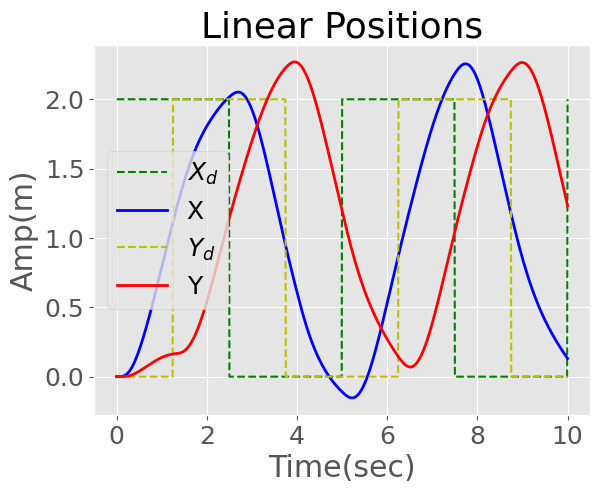

In [19]:
print("\n")
print("plot results ...\n\n")
plt.figure()
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 18})
plt.tight_layout()

plt.title("Linear Positions")
plt.plot(t, Xd[:-1, 8], 'g--', label=r"$X_d$")
plt.plot(t, Xs[:, 8], label="X", color='b', linewidth=2)
plt.plot(t, Xd[:-1, 10], 'y--', label=r"$Y_d$")
plt.plot(t, Xs[:, 10], label="Y", color='r', linewidth=2)
plt.xlabel('Time(sec)')
plt.ylabel("Amp(m)")
plt.legend(loc='best')

# plt.savefig('Position_xy_constant5', dpi=1200)
plt.show()

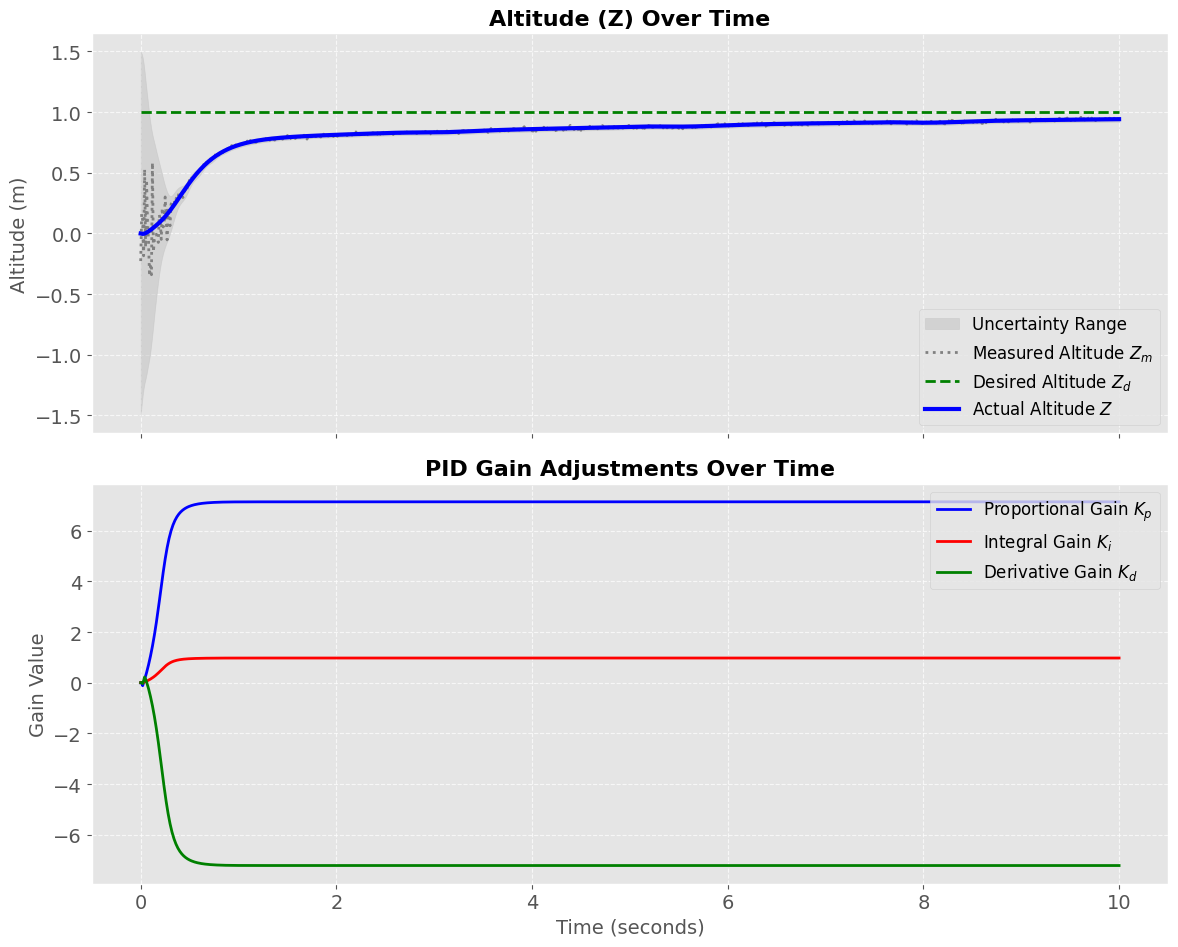

In [20]:
# %% -------------------- Altitude ---------------------------------------- #
import matplotlib.pyplot as plt

# Create the figure and subplots
plt.figure(figsize=(12, 10))  # Adjusted size for better readability
plt.style.use('ggplot')  # Use ggplot style
plt.rcParams.update({'font.size': 14})  # Adjust font size for better visibility
plt.tight_layout()

# Subplot for Altitude
plt1 = plt.subplot2grid((12, 1), (0, 0), rowspan=6, colspan=1)
plt1.set_title("Altitude (Z) Over Time", fontsize=16, fontweight='bold')
plt1.fill_between(t, z_lower, z_upper, color='silver', alpha=0.5, label="Uncertainty Range")
plt1.plot(t, z_m, label=r"Measured Altitude $Z_m$", color='grey', linewidth=2, linestyle='dotted')
plt1.plot(t, Xd[0:-1, 6], 'g--', label=r"Desired Altitude $Z_d$", linewidth=2)
plt1.plot(t, Xs[:, 6], label=r"Actual Altitude $Z$", color='b', linewidth=3)
plt1.set_ylabel("Altitude (m)", fontsize=14)
plt1.legend(loc="lower right", fontsize=12)
plt1.grid(True, linestyle='--', alpha=0.7)
plt1.set_xticklabels([])  # Remove x-ticks for alignment with lower subplot

# Subplot for PID Gains
plt2 = plt.subplot2grid((12, 1), (6, 0), rowspan=6, colspan=1)
plt2.set_title("PID Gain Adjustments Over Time", fontsize=16, fontweight='bold')
plt2.plot(t, Kp_z[1:] - Kp_z_static, label=r"Proportional Gain $K_p$", color='b', linewidth=2)
plt2.plot(t, Ki_z[1:] - Ki_z_static, label=r"Integral Gain $K_i$", color='r', linewidth=2)
plt2.plot(t, Kd_z[1:] - Kd_z_static, label=r"Derivative Gain $K_d$", color='g', linewidth=2)
plt2.set_xlabel("Time (seconds)", fontsize=14)
plt2.set_ylabel("Gain Value", fontsize=14)
plt2.legend(loc="upper right", fontsize=12)
plt2.grid(True, linestyle='--', alpha=0.7)

# Final adjustments
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit titles
plt.show()


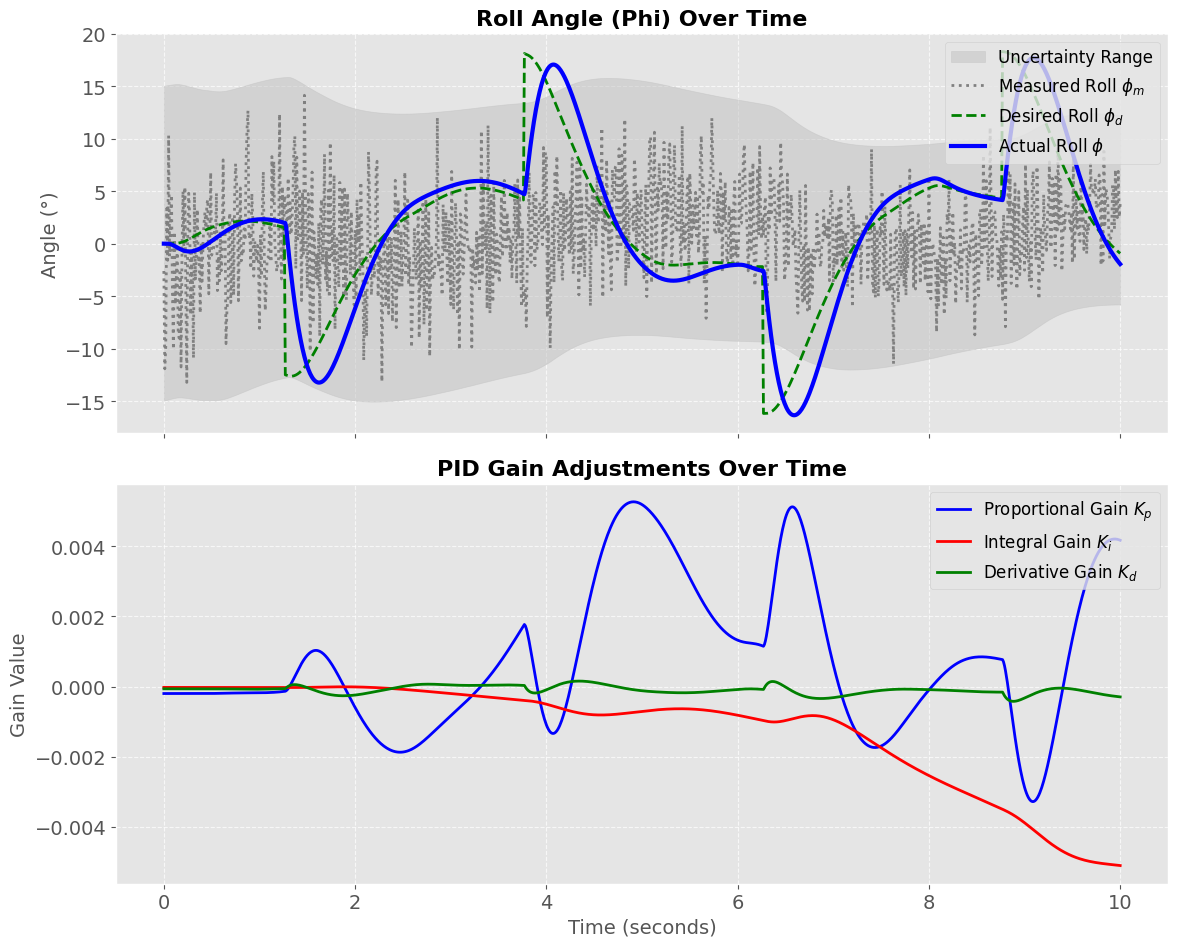

In [21]:
# %% -------------------- Roll Angle (Phi) -------------------------------- #
import matplotlib.pyplot as plt
import numpy as np

# Create figure
plt.figure(figsize=(12, 10))  # Adjusted figure size
plt.style.use('ggplot')  # Apply ggplot style
plt.rcParams.update({'font.size': 14})  # Adjust font size for better readability

# Subplot for Roll Angle
plt1 = plt.subplot2grid((12, 1), (0, 0), rowspan=6, colspan=1)
plt1.set_title("Roll Angle (Phi) Over Time", fontsize=16, fontweight='bold')
plt1.fill_between(t, phi_lower, phi_upper, color='silver', alpha=0.5, label="Uncertainty Range")
plt1.plot(t, np.rad2deg(phi_m), label=r"Measured Roll $\phi_m$", color='grey', linewidth=2, linestyle='dotted')
plt1.plot(t, np.rad2deg(Xd[0:-1, 0]), 'g--', label=r"Desired Roll $\phi_d$", linewidth=2)
plt1.plot(t, np.rad2deg(Xs[:, 0]), label=r"Actual Roll $\phi$", color='b', linewidth=3)
plt1.set_ylabel("Angle (°)", fontsize=14)
plt1.legend(loc="upper right", fontsize=12)
plt1.grid(True, linestyle='--', alpha=0.7)
plt1.set_xticklabels([])  # Remove x-ticks for alignment with lower subplot

# Subplot for PID Gains
plt2 = plt.subplot2grid((12, 1), (6, 0), rowspan=6, colspan=1)
plt2.set_title("PID Gain Adjustments Over Time", fontsize=16, fontweight='bold')
plt2.plot(t, Kp_phi[1:] - Kp_phi_static, label=r"Proportional Gain $K_p$", color='b', linewidth=2)
plt2.plot(t, Ki_phi[1:] - Ki_phi_static, label=r"Integral Gain $K_i$", color='r', linewidth=2)
plt2.plot(t, Kd_phi[1:] - Kd_phi_static, label=r"Derivative Gain $K_d$", color='g', linewidth=2)
plt2.set_xlabel("Time (seconds)", fontsize=14)
plt2.set_ylabel("Gain Value", fontsize=14)
plt2.legend(loc="upper right", fontsize=12)
plt2.grid(True, linestyle='--', alpha=0.7)

# Final adjustments
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit titles
plt.show()


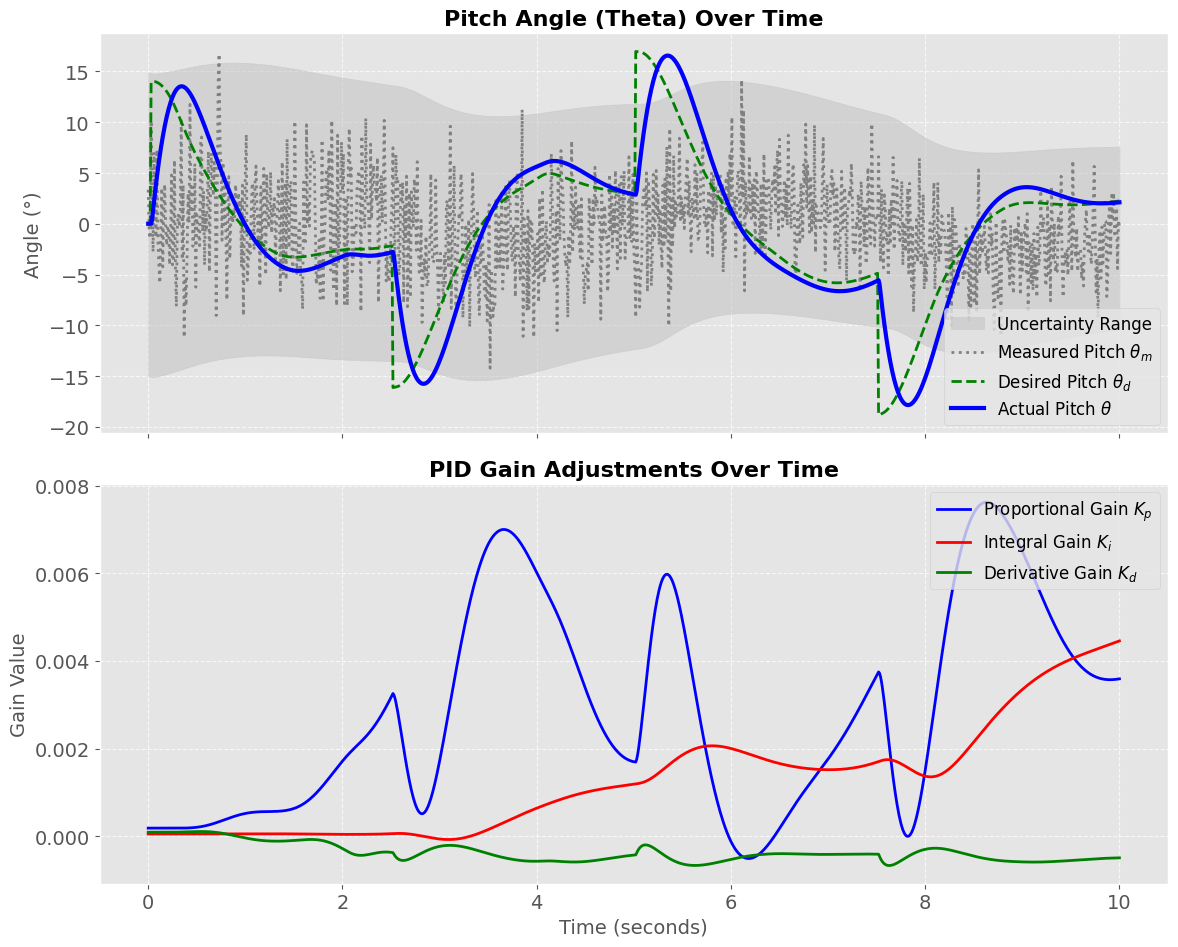

In [22]:
# %% -------------------- Pitch Angle (Theta) -------------------------------- #
import matplotlib.pyplot as plt
import numpy as np

# Create figure
plt.figure(figsize=(12, 10))  # Adjusted figure size
plt.style.use('ggplot')  # Apply ggplot style
plt.rcParams.update({'font.size': 14})  # Adjust font size for better readability

# Subplot for Pitch Angle
plt1 = plt.subplot2grid((12, 1), (0, 0), rowspan=6, colspan=1)
plt1.set_title("Pitch Angle (Theta) Over Time", fontsize=16, fontweight='bold')
plt1.fill_between(t, tta_lower, tta_upper, color='silver', alpha=0.5, label="Uncertainty Range")
plt1.plot(t, np.rad2deg(tta_m), label=r"Measured Pitch $\theta_m$", color='grey', linewidth=2, linestyle='dotted')
plt1.plot(t, np.rad2deg(Xd[0:-1, 2]), 'g--', label=r"Desired Pitch $\theta_d$", linewidth=2)
plt1.plot(t, np.rad2deg(Xs[:, 2]), label=r"Actual Pitch $\theta$", color='b', linewidth=3)
plt1.set_ylabel("Angle (°)", fontsize=14)
plt1.legend(loc="lower right", fontsize=12)
plt1.grid(True, linestyle='--', alpha=0.7)
plt1.set_xticklabels([])  # Remove x-ticks for alignment with lower subplot

# Subplot for PID Gains
plt2 = plt.subplot2grid((12, 1), (6, 0), rowspan=6, colspan=1)
plt2.set_title("PID Gain Adjustments Over Time", fontsize=16, fontweight='bold')
plt2.plot(t, Kp_tta[1:] - Kp_tta_static, label=r"Proportional Gain $K_p$", color='b', linewidth=2)
plt2.plot(t, Ki_tta[1:] - Ki_tta_static, label=r"Integral Gain $K_i$", color='r', linewidth=2)
plt2.plot(t, Kd_tta[1:] - Kd_tta_static, label=r"Derivative Gain $K_d$", color='g', linewidth=2)
plt2.set_xlabel("Time (seconds)", fontsize=14)
plt2.set_ylabel("Gain Value", fontsize=14)
plt2.legend(loc="upper right", fontsize=12)
plt2.grid(True, linestyle='--', alpha=0.7)

# Final adjustments
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit titles
plt.show()


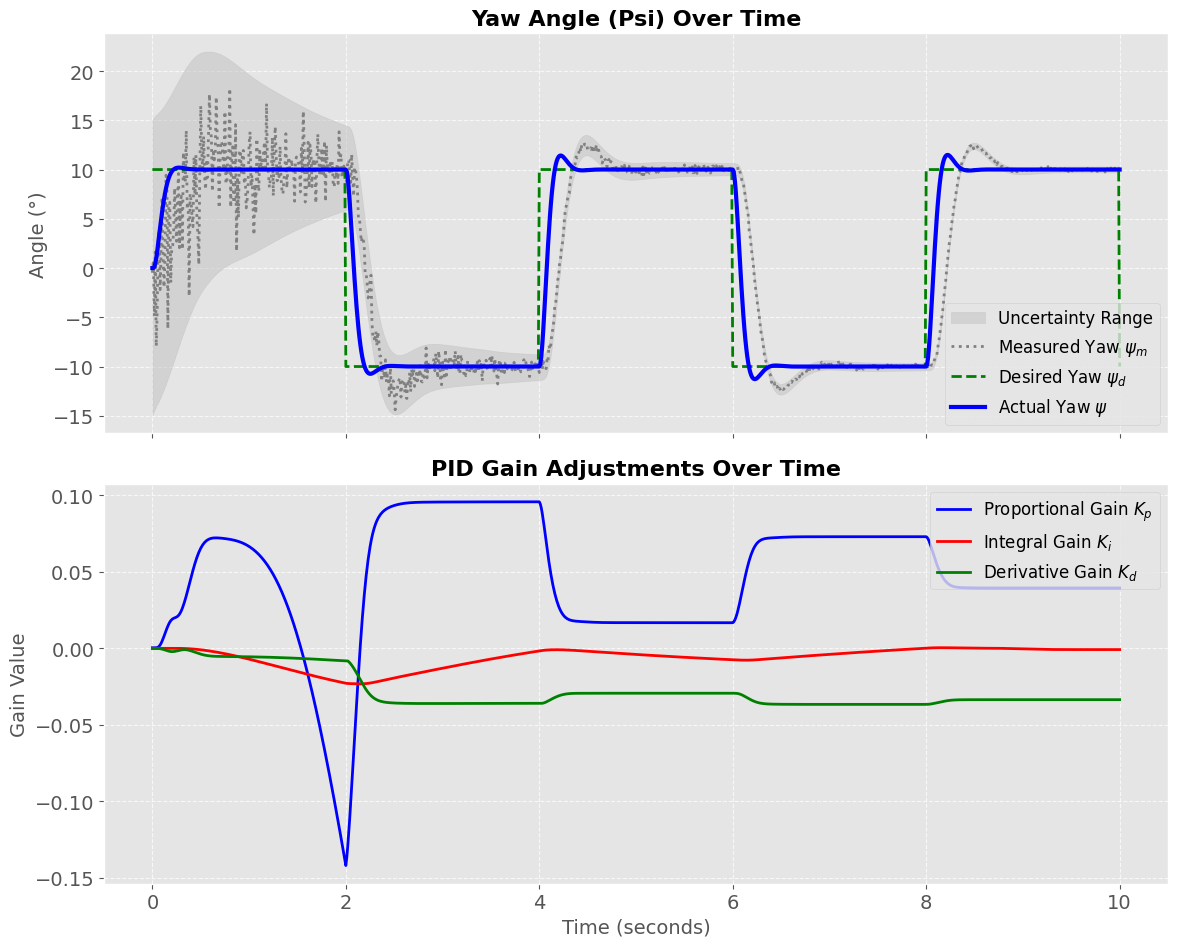

In [23]:
# %% -------------------- Yaw Angle (Psi) -------------------------------- #

# Create figure
plt.figure(figsize=(12, 10))  # Adjusted figure size
plt.style.use('ggplot')  # Apply ggplot style
plt.rcParams.update({'font.size': 14})  # Adjust font size for better readability

# Subplot for Yaw Angle
plt1 = plt.subplot2grid((12, 1), (0, 0), rowspan=6, colspan=1)
plt1.set_title("Yaw Angle (Psi) Over Time", fontsize=16, fontweight='bold')
plt1.fill_between(t, psi_lower, psi_upper, color='silver', alpha=0.5, label="Uncertainty Range")
plt1.plot(t, np.rad2deg(psi_m), label=r"Measured Yaw $\psi_m$", color='grey', linewidth=2, linestyle='dotted')
plt1.plot(t, np.rad2deg(Xd[0:-1, 4]), 'g--', label=r"Desired Yaw $\psi_d$", linewidth=2)
plt1.plot(t, np.rad2deg(Xs[:, 4]), label=r"Actual Yaw $\psi$", color='b', linewidth=3)
plt1.set_ylabel("Angle (°)", fontsize=14)
plt1.legend(loc="lower right", fontsize=12)
plt1.grid(True, linestyle='--', alpha=0.7)
plt1.set_xticklabels([])  # Remove x-ticks for alignment with lower subplot

# Subplot for PID Gains
plt2 = plt.subplot2grid((12, 1), (6, 0), rowspan=6, colspan=1)
plt2.set_title("PID Gain Adjustments Over Time", fontsize=16, fontweight='bold')
plt2.plot(t, Kp_psi[1:] - Kp_psi_static, label=r"Proportional Gain $K_p$", color='b', linewidth=2)
plt2.plot(t, Ki_psi[1:] - Ki_psi_static, label=r"Integral Gain $K_i$", color='r', linewidth=2)
plt2.plot(t, Kd_psi[1:] - Kd_psi_static, label=r"Derivative Gain $K_d$", color='g', linewidth=2)
plt2.set_xlabel("Time (seconds)", fontsize=14)
plt2.set_ylabel("Gain Value", fontsize=14)
plt2.legend(loc="upper right", fontsize=12)
plt2.grid(True, linestyle='--', alpha=0.7)

# Final adjustments
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit titles
plt.show()


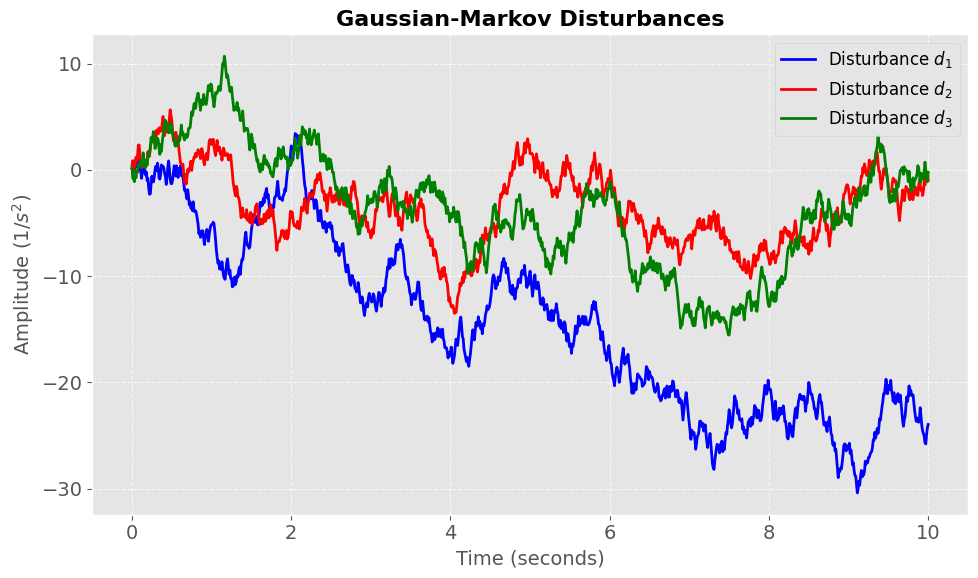

In [24]:
# %% -------------------- Gaussian-Markov Disturbances ---------------------- #

# Create figure
plt.figure(figsize=(10, 6))  # Adjusted figure size for better readability
plt.style.use('ggplot')  # Apply ggplot style
plt.rcParams.update({'font.size': 14})  # Set font size for consistency

# Title
plt.title("Gaussian-Markov Disturbances", fontsize=16, fontweight='bold')

# Disturbance signals
plt.plot(t, Xs[:, 12], label=r"Disturbance $d_1$", color='b', linewidth=2)
plt.plot(t, Xs[:, 13], label=r"Disturbance $d_2$", color='r', linewidth=2)
plt.plot(t, Xs[:, 14], label=r"Disturbance $d_3$", color='g', linewidth=2)

# Labels and legends
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("Amplitude ($1/s^2$)", fontsize=14)
plt.legend(loc="best", fontsize=12)  # Automatically choose the best legend position
plt.grid(True, linestyle='--', alpha=0.7)  # Subtle gridlines for clarity

# Final adjustments
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


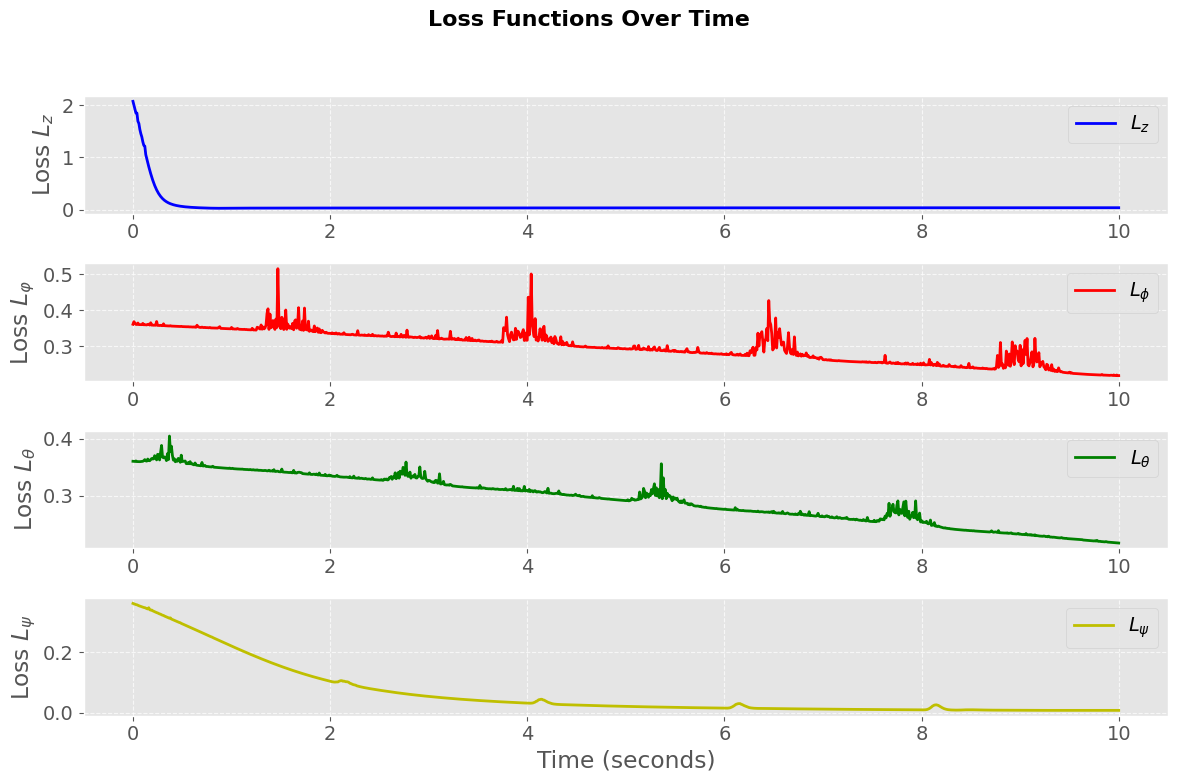

In [25]:
# %% -------------------- Loss Functions ---------------------- #
import matplotlib.pyplot as plt

# Create figure with adjusted size
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')  # Apply ggplot style
plt.rcParams.update({'font.size': 14})  # Adjust font size for consistency

# Title
plt.suptitle("Loss Functions Over Time", fontsize=16, fontweight='bold')

# Subplots for each loss function
plt1 = plt.subplot2grid((4, 1), (0, 0), rowspan=1, colspan=1)
plt2 = plt.subplot2grid((4, 1), (1, 0), rowspan=1, colspan=1)
plt3 = plt.subplot2grid((4, 1), (2, 0), rowspan=1, colspan=1)
plt4 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, colspan=1)

# Plot L_z
plt1.plot(t, z_agent_losses, label=r'$L_z$', color='b', linewidth=2)
plt1.set_ylabel("Loss $L_z$")
plt1.legend(loc="best")
plt1.grid(alpha=0.7, linestyle='--')  # Subtle gridlines for better readability

# Plot L_phi
plt2.plot(t, phi_agent_losses, label=r'$L_\phi$', color='r', linewidth=2)
plt2.set_ylabel("Loss $L_φ$")
plt2.legend(loc="best")
plt2.grid(alpha=0.7, linestyle='--')

# Plot L_tta
plt3.plot(t, tta_agent_losses, label=r'$L_\theta$', color='g', linewidth=2)
plt3.set_ylabel("Loss $L_θ$")
plt3.legend(loc="best")
plt3.grid(alpha=0.7, linestyle='--')

# Plot L_psi
plt4.plot(t, psi_agent_losses, label=r'$L_\psi$', color='y', linewidth=2)
plt4.set_ylabel("Loss $L_ψ$")
plt4.set_xlabel("Time (seconds)")
plt4.legend(loc="best")
plt4.grid(alpha=0.7, linestyle='--')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
plt.show()


In [26]:
# %% Save Data
# from save_data import save_data
# self_tuning = 1
# if self_tuning == 1:
#     filename = "saved_data\\A2C_PID_data_with_SQUARE_path"
# else:
#     filename = "saved_data\\PID_data_with_Guassian_Dist_seed2"

# # with open(filename+"1.npy", 'wb') as f:
# #     np.save(f,Xs)

# save_data(filename+".xlsx", t, Xs, Xd, M)

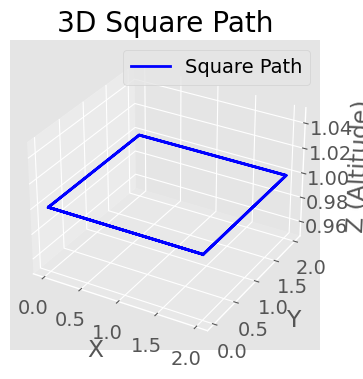

In [27]:
fig = plt.figure(figsize=(4, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xd[:, 8], Xd[:, 10], Xd[:, 6], label='Square Path', color='b', linewidth=2)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z (Altitude)')
ax.set_title('3D Square Path')

plt.legend()
plt.show()


In [ ]:
print("done!")

done!


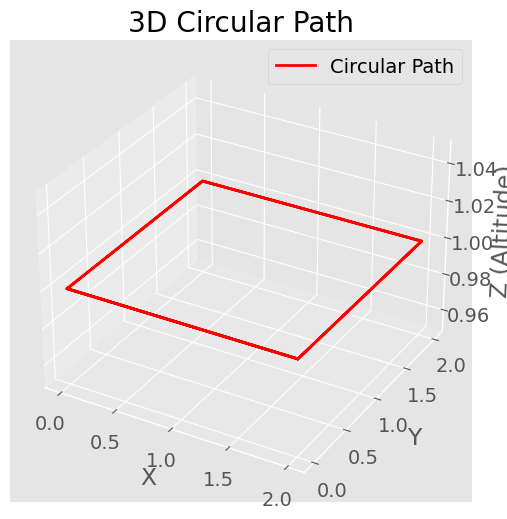

In [29]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xd[:, 8], Xd[:, 10], Xd[:, 6], label='Circular Path', color='r', linewidth=2)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z (Altitude)')
ax.set_title('3D Circular Path')

plt.legend()
plt.show()
